In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
print(survivalstan.models.pem_survival_model_gamma)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // data
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 obs_t      = observed end time for interval for timepoint for that obs
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<lower=0, upper=1> event[N]; // 1: event, 0:censor
  matrix[N, M] x;                 // explanatory vars
  real<lower=0> obs_t[N];         // observed end time for each obs
  real<lower=0> t_dur[T];
  real<lower=0> t_obs[T];
}
t

In [3]:
d = survivalstan.sim.sim_data_exp_correlated(N=100,
                                             censor_time=20,
                                             rate_form='1 + sex',
                                             rate_coefs=[-3, 0.5])
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

,age,sex,rate,true_t,t,event,index,age_centered
0,45,male,0.082085,42.711246,20.000000,False,0,-10.46
1,67,male,0.082085,4.824585,4.824585,True,1,11.54
2,51,female,0.049787,4.207328,4.207328,True,2,-4.46
3,57,female,0.049787,9.274522,9.274522,True,3,1.54
4,59,male,0.082085,24.378487,20.000000,False,4,3.54


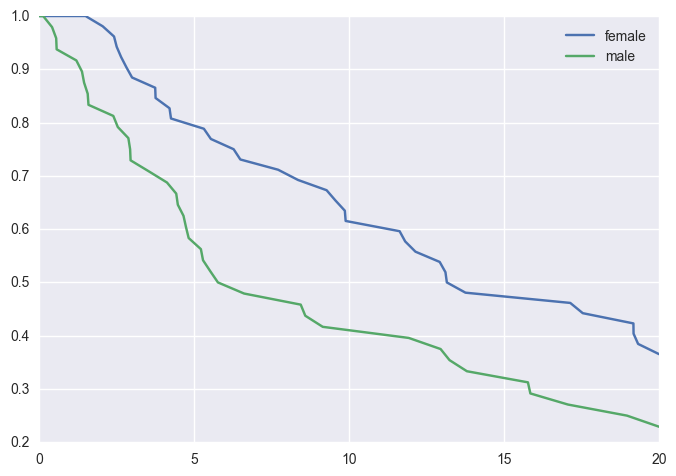

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [5]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')

In [6]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
0,45,male,0.082085,42.711246,20.0,False,0,-10.46,1,20.000000,False
1,45,male,0.082085,42.711246,20.0,False,0,-10.46,1,4.824585,False
2,45,male,0.082085,42.711246,20.0,False,0,-10.46,1,4.207328,False
3,45,male,0.082085,42.711246,20.0,False,0,-10.46,1,9.274522,False
4,45,male,0.082085,42.711246,20.0,False,0,-10.46,1,5.768873,False


In [7]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model_gamma,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 1000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_72990130769.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e9967af60f8a4c8a22e064ae4316828 NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:00:40.615406 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_72990130769.pystan_2_12_0_0.stanfit.chains_4.data_69800167510.iter_1000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:02:57.819555 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/Users/jburos/anaconda/envs/python3/lib

In [8]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__ -961.196918  0.562245  6.999897 -974.788391 -960.907587 -948.504081  1.036954


In [10]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline')

                        mean    se_mean          sd        2.5%         50%     97.5%      Rhat
log_baseline[0]    -5.395582   0.072011    1.222060   -8.282748   -5.232844 -3.552033  1.012455
log_baseline[1]    -5.451295   0.064019    1.206219   -8.282490   -5.271863 -3.550327  1.007882
log_baseline[2]    -5.453931   0.080644    1.302846   -8.348155   -5.235857 -3.558643  1.014293
log_baseline[3]    -5.435776   0.065958    1.247979   -8.246206   -5.306790 -3.426184  1.009949
log_baseline[4]    -5.528530   0.057730    1.239513   -8.619080   -5.398841 -3.555590  1.007695
log_baseline[5]    -5.316014   0.046509    1.080779   -7.846767   -5.166897 -3.616477  1.010514
log_baseline[6]    -5.487513   0.080583    1.309325   -8.533384   -5.281994 -3.536491  1.001989
log_baseline[7]    -5.496746   0.080407    1.276428   -8.461880   -5.299376 -3.554871  1.015485
log_baseline[8]    -5.416139   0.073717    1.297924   -8.624220   -5.198958 -3.513511  1.009605
log_baseline[9]    -5.399942   0.068829 

INFO:survivalstan.utils:Warning - 1 rows removed due to NaN values for Rhat. This may indicate a problem in your model estimation.
/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


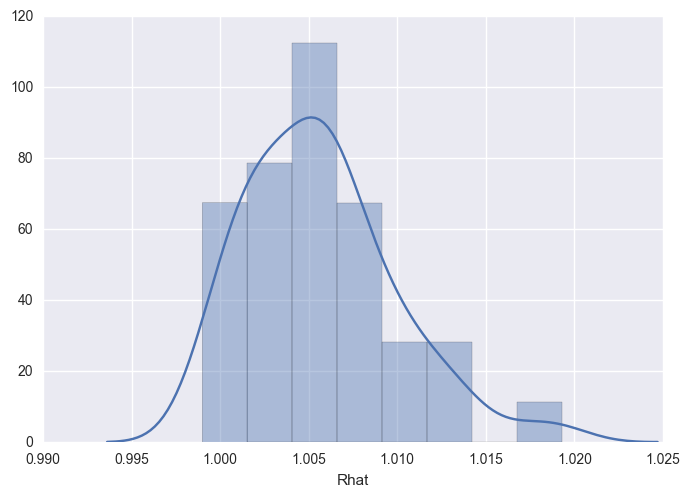

In [11]:
survivalstan.utils.plot_stan_summary([testfit], pars='baseline')

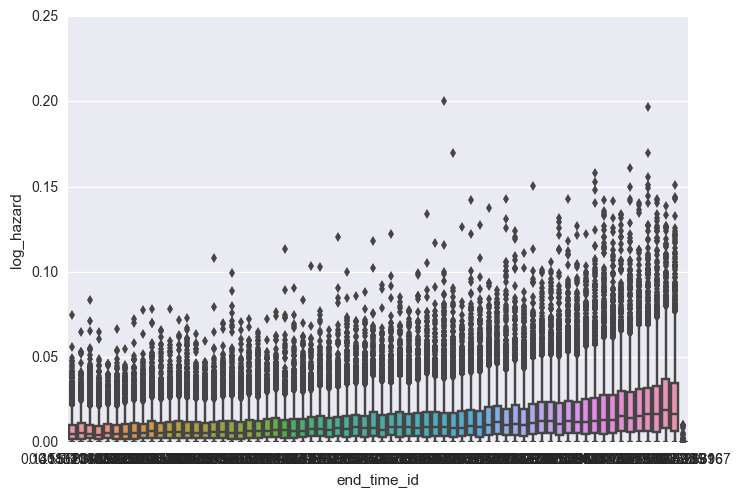

In [12]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

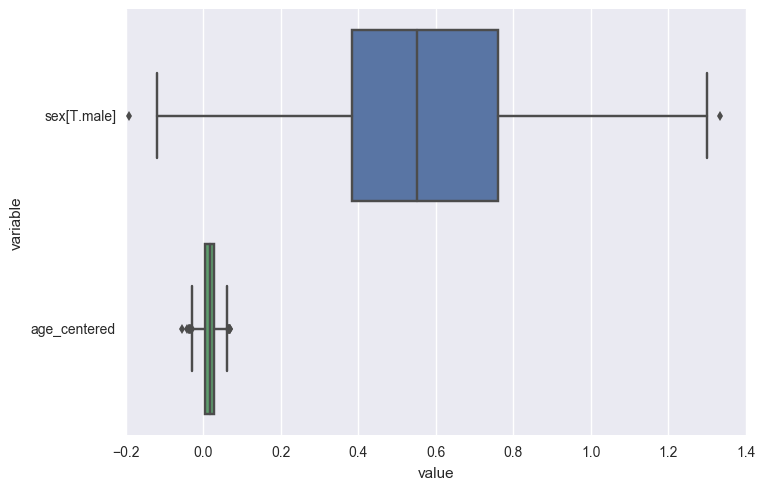

In [13]:
survivalstan.utils.plot_coefs([testfit])

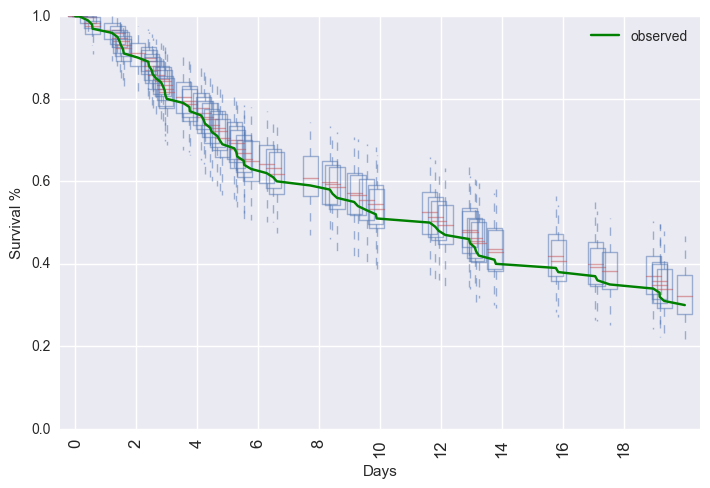

In [14]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

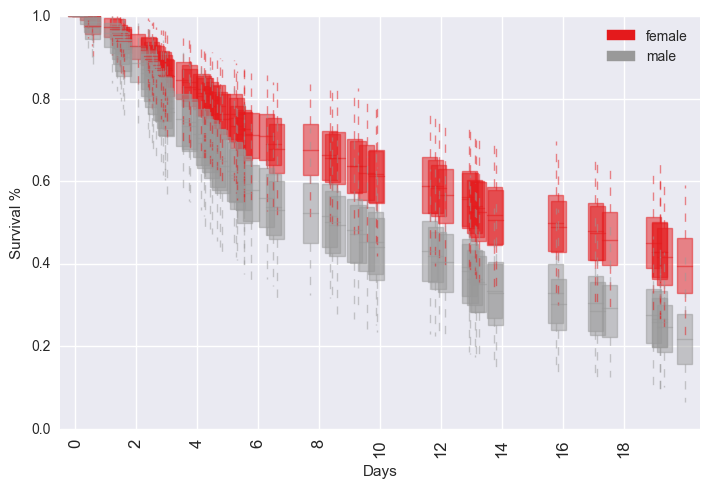

In [16]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')